<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Recurrent Neural Networks (RNNs)

_Author: Riley Dallas (ATX), Patrick Wales-Dinan (SF)_

---


### Learning Objectives

- Learn how to train/test split for sequence data
- Use `TimeseriesGenerator` to prep our time series data for modeling
- Create a basic RNN model using `keras`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

## Load data: AAPL stock prices and SEC filings
---

There are two datasets that we'll merge together:
- Apple's historical stock prices (ticker: AAPL)
- Their SEC filings:
  - Annual earnings reports: 10-K
  - Quarterly earnings reports: 10-Q
  - Company news and updates: 8-K

Load both in the cells below.

In [2]:
# load prices
prices = pd.read_csv('../datasets/AAPL.csv')
prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
1,2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2,2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
3,2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
4,2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [3]:
# load filings
filings = pd.read_csv('../datasets/filings.csv')
filings.head()

,Date,10-K,10-Q,8-K
0,1994-12-13,1.0,0.0,0.0
1,1995-12-19,1.0,0.0,0.0
2,1996-12-19,1.0,0.0,0.0
3,1997-12-05,1.0,0.0,0.0
4,1999-12-22,1.0,0.0,0.0


## `Date` columns
---

For both datasets, we need to:
1. Convert the `Date` column to be a `datetime` object
2. Since these are time series datasets, we need the indices to be the `Date` columns

In [4]:
# set prices Date to datetime
prices['Date'] = pd.to_datetime(prices['Date'])

In [5]:
# set prices index to Date column
prices.set_index('Date', inplace=True)
prices.sort_index(inplace=True)
prices.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-04-25,5.212857,5.288571,5.158571,5.282857,3.522625,186615100
2005-04-26,5.254286,5.358572,5.160000,5.170000,3.447372,202626900
2005-04-27,5.127143,5.194286,5.072857,5.135714,3.424510,153472200
2005-04-28,5.184286,5.191429,5.034286,5.077143,3.385454,143776500
2005-04-29,5.164286,5.175714,5.031428,5.151429,3.434988,167907600


In [6]:
# set filings Date to datetime
filings['Date'] = pd.to_datetime(filings['Date'])
# set filings index to Date column
filings.set_index('Date', inplace=True)
filings.sort_index(inplace=True)
filings.head()

,10-K,10-Q,8-K
Date,,,
1994-12-13,1.0,0.0,0.0
1995-12-19,1.0,0.0,0.0
1996-12-19,1.0,0.0,0.0
1997-12-05,1.0,0.0,0.0
1999-12-22,1.0,0.0,0.0


## Data cleaning: Prices
---

For Apple's stock prices, we'll need to do a few things:
1. Drop the `Adj Close` column since we already have a `Close` price
2. De-trend the dataset using `.pct_change()`
3. Drop any `NaN`s that were created from step 2

In [7]:
# Drop Adj Close column
prices.drop(columns='Adj Close', inplace=True)

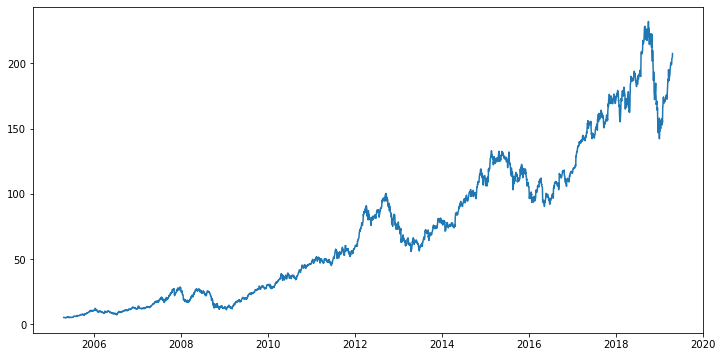

In [8]:
# Plot Close column
plt.figure(figsize=(12, 6))
plt.plot(prices['Close']);

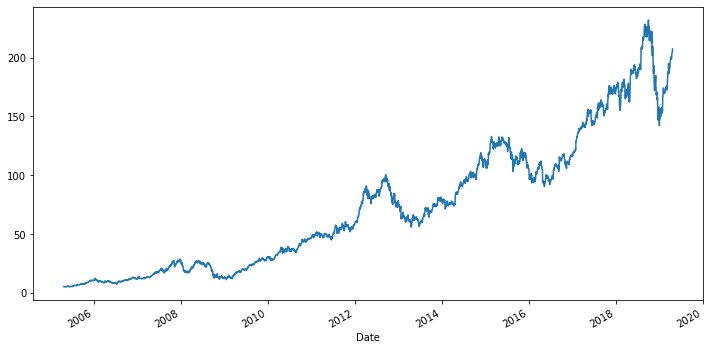

In [9]:
## Another way to plot using the pandas plot method
prices['Close'].plot(figsize = (12,6));

In [10]:
# Convert prices to be percent changes from prior row
prices = prices.pct_change()
prices.head()

,Open,High,Low,Close,Volume
Date,,,,,
2005-04-25,NaN,NaN,NaN,NaN,NaN
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838


In [11]:
# Drop nulls
prices.dropna(inplace=True)

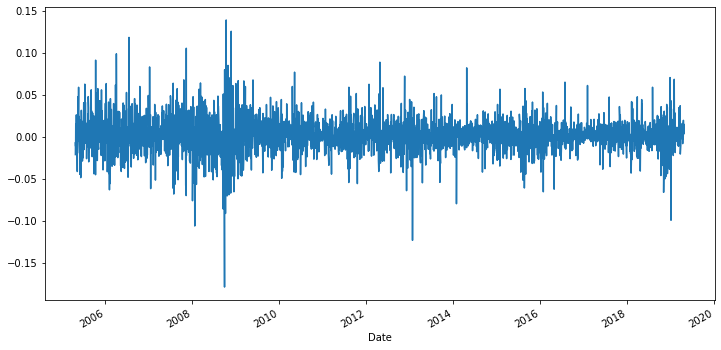

In [12]:
# Plot Close column again
prices['Close'].plot(figsize = (12,6));

## Create `Target` column
---

Our column of interest is the `Close` prices. We could build a regression model, where we predict the actual percentage change, or we could set this up as a binary classification problem:
- 1: The `Close` price was greater than or equal to the previous day
- 0: The `Close` price was lower than the previous day

We'll go with the latter option. In the cell below, let's create our binary `Target` column.

In [13]:
# Create Target column
prices['Target'] = (prices['Close'] >= 0).astype(int)

prices.head()

,Open,High,Low,Close,Volume,Target
Date,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1


## Merge Prices with SEC filings
---

SEC filings tend to have a huge impact on stock prices. Because of this, we'll want to merge the prices and filings `DataFrames` together.

<details><summary>What kind of join should we use here?</summary>

We'll want to do a left join, so that we don't lose any rows that aren't associated with any SEC filings.
</details>

In [14]:
prices.shape

(3522, 6)

In [15]:
filings.shape

(100, 3)

In [16]:
## What happens if we do a merge with default join (inner)?
pd.merge(prices, filings, left_index=True, right_index=True).shape

(91, 9)

In [17]:
# Merge DataFrames
df = pd.merge(prices, filings,
              left_index=True, right_index=True,
              how='left')

df.head()

,Open,High,Low,Close,Volume,Target,10-K,10-Q,8-K
Date,,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0,NaN,NaN,NaN
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0,NaN,NaN,NaN
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0,NaN,NaN,NaN
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1,NaN,NaN,NaN
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1,NaN,NaN,NaN


## Fill `NaN`s
---

After the merge, we now have a bunch of `NaN`s for rows that didn't have any SEC filings on that date. Let's fill those in with 0.

In [18]:
## Check for nulls
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Volume       0
Target       0
10-K      3431
10-Q      3431
8-K       3431
dtype: int64

In [19]:
# Fill Nans with 0
df.fillna(0, inplace=True)

df.head()

,Open,High,Low,Close,Volume,Target,10-K,10-Q,8-K
Date,,,,,,,,,
2005-04-26,0.007947,0.013236,0.000277,-0.021363,0.085801,0,0.0,0.0,0.0
2005-04-27,-0.024198,-0.030659,-0.016888,-0.006632,-0.242587,0,0.0,0.0,0.0
2005-04-28,0.011145,-0.000550,-0.007603,-0.011405,-0.063176,0,0.0,0.0,0.0
2005-04-29,-0.003858,-0.003027,-0.000568,0.014631,0.167838,1,0.0,0.0,0.0
2005-05-02,0.001660,0.011593,0.022714,0.010261,-0.306285,1,0.0,0.0,0.0


## Train/Test Split
---

Since we're dealing with time series data, we don't want the model to be able to see the future. 

<details><summary>What do we need to do in train_test_split?</summary>

- set `shuffle=False` so that the order is maintained
</details>

In [20]:
# Create X and y
X = df.drop(columns='Target')
y = df['Target']

In [21]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.1)


In [22]:
X_train.shape, X_test.shape

((3169, 8), (353, 8))

In [23]:
y_train.mean(), y_test.mean()

(0.5263490059955822, 0.546742209631728)

## Scaling
---

You want to scale your data for any model that uses gradient descent, which includes neural networks.

In [24]:
# Scale
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

Train shape: (3169, 8)
Test shape: (353, 8)


## `TimeseriesGenerator`
---

We'll now convert our data into series' using `TimeseriesGenerator`. The `length` parameter dictates how many rows will constitute a sample. The generator also creates our batches.

```python
train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=3, batch_size=64)
```

In the cells below, convert your training and validation data into sequences.

In [25]:
# Create training sequences
train_seq = TimeseriesGenerator(X_train_sc, y_train,
                                length=3, batch_size=64)

In [26]:
## Inspect our training sequences
batch_x, batch_y = train_seq[0]

In [27]:
## Check batch X shape
batch_x.shape

(64, 3, 8)

In [28]:
## Check batch y shape
batch_y.shape

(64,)

In [29]:
## Inspect batch X
batch_x[0:3]

array([[[ 0.29765124,  0.69170053, -0.05043447, -1.10084791,
          0.06716994, -0.06418051, -0.10567799, -0.09610239],
        [-1.15275553, -1.84222756, -0.87529289, -0.38583241,
         -0.74856034, -0.06418051, -0.10567799, -0.09610239],
        [ 0.44193324, -0.10414528, -0.42912132, -0.61749897,
         -0.30289454, -0.06418051, -0.10567799, -0.09610239]],

       [[-1.15275553, -1.84222756, -0.87529289, -0.38583241,
         -0.74856034, -0.06418051, -0.10567799, -0.09610239],
        [ 0.44193324, -0.10414528, -0.42912132, -0.61749897,
         -0.30289454, -0.06418051, -0.10567799, -0.09610239],
        [-0.23500478, -0.2471402 , -0.09102684,  0.64623238,
          0.27095165, -0.06418051, -0.10567799, -0.09610239]],

       [[ 0.44193324, -0.10414528, -0.42912132, -0.61749897,
         -0.30289454, -0.06418051, -0.10567799, -0.09610239],
        [-0.23500478, -0.2471402 , -0.09102684,  0.64623238,
          0.27095165, -0.06418051, -0.10567799, -0.09610239],
        [ 0.

In [30]:
## Compare to our scaled data (put into a dataframe for readability)
pd.DataFrame(X_train_sc, columns=X_train.columns).head(3)

,Open,High,Low,Close,Volume,10-K,10-Q,8-K
0,0.297651,0.691701,-0.050434,-1.100848,0.067170,-0.064181,-0.105678,-0.096102
1,-1.152756,-1.842228,-0.875293,-0.385832,-0.748560,-0.064181,-0.105678,-0.096102
2,0.441933,-0.104145,-0.429121,-0.617499,-0.302895,-0.064181,-0.105678,-0.096102


In [31]:
# Create test sequences
test_seq = TimeseriesGenerator(X_test_sc, y_test,
                               length=3, batch_size=64)

## Modeling time!
---

Now it's time to design our RNN model. We'll have:

- 2 `GRU` layers
- 1 `Dense` output layer

We're doing a binary classification problem.

<details><summary>What should our output layer look like?</summary>

- 1 neuron
- sigmoid activation function
- this way, our model predicts a probability
</details>

In [32]:
train_seq[0][0][0].shape

(3, 8)

In [33]:
# Design RNN
model = Sequential()

model.add(GRU(64, input_shape = train_seq[0][0][0].shape,
              return_sequences = True)) # returns hidden state & passes back into layer

model.add(GRU(8, return_sequences = False)) # passes outputs forward to next layer

model.add(Dense(8, activation = 'relu')) # Eight nodes because it must have the same number as the preceding GRU layer
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', loss = 'bce', metrics=['acc'])

history = model.fit(train_seq,
                    epochs = 50,
                    verbose = 0,
                    validation_data = test_seq)

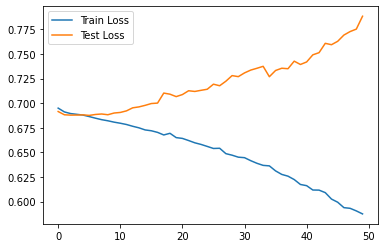

In [34]:
## Plot Training and Validation Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();

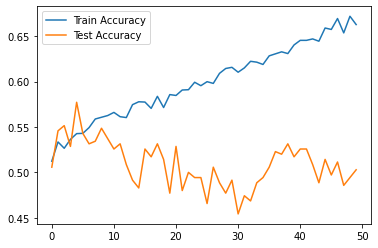

In [35]:
## Plot Training and Validation Accuracy
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Test Accuracy')
plt.legend();

## Your turn!
---

Can you improve this model? Try to build a model that minimizes the testing loss even more!

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

model2 = Sequential()

model2.add(GRU(64, input_shape=train_seq[0][0][0].shape,
               return_sequences=True))
model2.add(GRU(32, return_sequences = True))
model2.add(GRU(16, return_sequences = False))

model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.1))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer = Adam(learning_rate=0.0001),
               loss='bce', metrics=['acc'])

es = EarlyStopping(patience=3)

history2 = model2.fit(train_seq,
                      epochs=50,
                      verbose = 0,
                      validation_data= test_seq,
                      callbacks=[es])


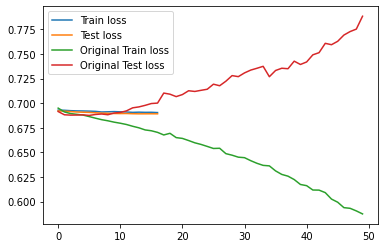

In [37]:
## Plot Training and Validation Loss (for both models)
plt.plot(history2.history['loss'], label='Train loss')
plt.plot(history2.history['val_loss'], label='Test loss')

plt.plot(history.history['loss'], label='Original Train loss')
plt.plot(history.history['val_loss'], label='Original Test loss')
plt.legend();

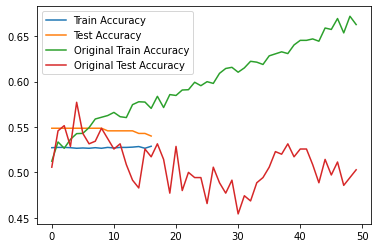

In [38]:
## Plot Training and Validation Loss (for both models)
plt.plot(history2.history['acc'], label='Train Accuracy')
plt.plot(history2.history['val_acc'], label='Test Accuracy')

plt.plot(history.history['acc'], label='Original Train Accuracy')
plt.plot(history.history['val_acc'], label='Original Test Accuracy')
plt.legend();